In [3]:
# Importing necessary libraries
# TODO:clean this
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from ast import literal_eval
import cv2
import keras
from tensorflow import keras
import tensorflow as tf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Layer, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
import json
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from collections import OrderedDict
import pyarrow.parquet as pa

In [4]:
# Define the Encoder class focusing only on the encoding part
class Encoder(nn.Module):
    def __init__(self, input_size, encoding_size):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, encoding_size),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.layers(x)
    
# Define input and encoding sizes
input_size = 768
encoding_size = 128
# encoding_size = 64
def load_encoder_state_dict(encoder, state_dict_path):
    state_dict = torch.load(state_dict_path)
    # Rename the state_dict keys to match the structure of the Encoder class
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        # Prepend 'layers.' to each key
        name = f'layers.{k}'
        new_state_dict[name] = v
    
    encoder.load_state_dict(new_state_dict)
    return encoder

def get_device():
    return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device = get_device()
# Instantiate the encoder
encoder = Encoder(input_size=input_size, encoding_size=encoding_size).to(device)
encoder.eval()  # Set the encoder to evaluation mode

# Load the pre-trained weights for the encoder for 64 embedding vector
# encoder = load_encoder_state_dict(encoder, '/home/mendu/Thesis/data/musiccaps/auto_encoder/encoder_state_dict.pth')

# Load the pre-trained weights for the encoder for 128 embedding vector
encoder = load_encoder_state_dict(encoder, '/home/mendu/Thesis/data/musiccaps/auto_encoder/encoder_state_dict128.pth')

# Load the SentenceTransformer model and move to the correct device
roberta_model = SentenceTransformer('/home/mendu/Thesis/data/musiccaps/new_embedding_model').to(device)

# Assuming df is a predefined DataFrame with text data
# caption = df.caption_writing[2]
# Function to encode caption
def encode_caption(encoder, sentence_model, text):
    with torch.no_grad():
        encoded_caption = sentence_model.encode(text, convert_to_tensor=True)
        encoded_caption = encoded_caption.to(device)
        return encoder(encoded_caption.unsqueeze(0))
    
# Encoded caption
# fully_encoded_caption = encode_caption(encoder, roberta_model, caption)

In [ ]:
df = pd.read_pickle('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_embeddings.pkl')

In [5]:
# df = pd.read_csv('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_captions.csv', index_col = [0])

# # Apply the encode_caption function to each row's caption_writing
# def get_encoded_caption(row):
#     caption = row['caption_writing']
#     return encode_caption(encoder, roberta_model, caption).cpu()


# df['caption_embedding'] = df.apply(get_encoded_caption, axis=1)

# # Flatten the nested list
# df['caption_embedding'] = df['caption_embedding'].apply(lambda x: np.array(x)[0])

# # Now df has an additional column with the caption embeddings as tensors
# df

,mp3_path,tags,caption_writing,caption_embedding
clip_id,,,,
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the majestic beauty of classical mu...,"[58.318653, 163.37714, 98.49955, 0.0, 121.7728..."
6,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the rich sound of classical eleganc...,"[53.57758, 167.8064, 86.76849, 0.0, 99.58538, ..."
10,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This powerful classic opera piece showcases th...,"[70.38409, 162.89124, 101.393654, 0.0, 122.321..."
11,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This atmospheric and introspective song blends...,"[122.84304, 152.52057, 143.20514, 0.0, 93.0801..."
14,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic,This upbeat dance track features a pulsing tec...,"[152.7225, 106.83787, 122.60301, 0.0, 12.84308..."
...,...,...,...,...
58896,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical guitar solo piece features intr...,"[89.40639, 110.51688, 94.25024, 0.0, 79.97659,..."
58897,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This beautiful classical piece features a haun...,"[57.00573, 144.95322, 99.65594, 0.0, 96.68577,..."
58898,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical piece features beautiful melodi...,"[60.028393, 145.84311, 90.767975, 0.0, 110.974..."


In [4]:
# df['caption_embedding'] = df['caption_embedding'].apply(lambda x: x[0])
# df

,mp3_path,tags,caption_writing,caption_embedding
clip_id,,,,
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the majestic beauty of classical mu...,"[58.318653, 163.37714, 98.49955, 0.0, 121.7728..."
6,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the rich sound of classical eleganc...,"[53.57758, 167.8064, 86.76849, 0.0, 99.58538, ..."
10,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This powerful classic opera piece showcases th...,"[70.38409, 162.89124, 101.393654, 0.0, 122.321..."
11,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This atmospheric and introspective song blends...,"[122.84304, 152.52057, 143.20514, 0.0, 93.0801..."
14,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic,This upbeat dance track features a pulsing tec...,"[152.7225, 106.83787, 122.60301, 0.0, 12.84308..."
...,...,...,...,...
58896,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical guitar solo piece features intr...,"[89.40639, 110.51688, 94.25024, 0.0, 79.97659,..."
58897,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This beautiful classical piece features a haun...,"[57.00573, 144.95322, 99.65594, 0.0, 96.68577,..."
58898,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical piece features beautiful melodi...,"[60.028393, 145.84311, 90.767975, 0.0, 110.974..."


In [8]:
# Save as pickle file
# df.to_pickle("/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_128embeddings.pkl")

In [6]:
# df = df[:500]

In [7]:
# Save to CSV
# df.to_csv('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_embeddings.csv', index=False)

# Save as pickle file
# df.to_pickle("/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_embeddings.pkl")

In [8]:
# temp_tensor = df.caption_embedding[0]
# temp_tensor

In [9]:
# temp_tensor = tf.cast(temp_tensor, tf.float32)

In [10]:
# temp_tensor

In [11]:
# new_shape = tf.reshape(temp_tensor, [64,])

In [12]:
# tf.shape(new_shape)

In [13]:
# new_shape

In [14]:
# tf.shape(temp_tensor)

## Training the model

In [5]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [8]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

In [9]:
df.tags.value_counts()

tags
electronic    3279
classical     3190
rock          1751
opera         1259
indian        1234
pop            431
country        354
new age        328
Name: count, dtype: int64

In [10]:
len(audio_names_list)

11826

In [11]:
data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
  filename_npy = str(filename[:-4]) + '.npy'
  file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
  img = np.load(file_path)
  data.append(add_gauss_noise(img))

  # To ensure that the files are getting loaded in the correct order
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)

american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-262-291.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-291-320.mp3
lvx_nova-lvx_nova-01-contimune-30-59.mp3
american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3
steven_devine-portrait_of_an_english_harpsichord-01-lesson_1_in_g_major_prelude_james_nares-30-59.mp3
the_headroom_project-jetuton_andawai-01-linda_morena-88-117.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-30-59.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-146-175.mp3


In [12]:
# Caption Embeddings
embeddings = df['caption_embedding']

In [13]:
len(embeddings)

11826

In [ ]:
data = np.load('data/magnatagatune/data_array.npy')

In [14]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(11826, 128, 1255)

In [15]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df[:500]['tags']), test_size=0.1, random_state=42)
# Split data into training and validation sets
X_train_spec, X_val_spec, X_train_embed, X_val_embed, y_train, y_val = train_test_split(data, embeddings, pd.get_dummies(df['tags']), test_size=0.1, random_state=42)

In [16]:
# First, ensure that each element is an array or list of length 64
for i, emb in enumerate(X_train_embed):
    if len(emb) != 64:
        print(f"Index {i} has an embedding of incorrect length: {len(emb)}")

# If the above check passes without printing anything, it means all embeddings have the correct length
# Now, convert this array of arrays into a proper 2D NumPy array
X_train_embed_array = np.stack(X_train_embed, axis=0)

# Check the new shape to ensure it's (450, 64)
print("Shape after conversion:", X_train_embed_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
X_train_embed_tensor = tf.convert_to_tensor(X_train_embed_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", X_train_embed_tensor.shape)

Shape after conversion: (10643, 64)
Tensor shape: (10643, 64)


2024-06-05 11:43:55.000916: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
# Convert the 1D array of arrays into a proper 2D NumPy array
X_val_embed_array = np.stack(X_val_embed, axis=0)

# Check the new shape to ensure it's in the correct format
print("Shape after conversion:", X_val_embed_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
X_val_embed_tensor = tf.convert_to_tensor(X_val_embed_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", X_val_embed_tensor.shape)

Shape after conversion: (1183, 64)
Tensor shape: (1183, 64)


In [18]:
# Convert training data to tensors
X_train_spec = tf.convert_to_tensor(X_train_spec, dtype=tf.float32)
# X_train_embed = tf.convert_to_tensor(X_train_embed, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Convert validation data to tensors
X_val_spec = tf.convert_to_tensor(X_val_spec, dtype=tf.float32)
# X_val_embed = tf.convert_to_tensor(X_val_embed, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [19]:
data.shape

(11826, 128, 1255, 1)

In [20]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train_spec)

In [21]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

8

In [22]:
data[0].shape

(128, 1255, 1)

In [23]:
class ModelSubClassing(keras.Model):
    def __init__(self, num_classes):
        super().__init__()
        # Layer of Block 1
        self.conv1 = Conv2D(32, 3, strides=2, activation="relu")
        self.max1  = MaxPooling2D(3)
        self.bn1   = BatchNormalization()

        # Layer of Block 2
        self.conv2 = Conv2D(64, 3, activation="relu")
        self.bn2   = BatchNormalization()
        self.max2  = MaxPooling2D(3)
        self.drop1 = Dropout(0.3)
        
        # Layer of Block 3
        self.conv3 = Conv2D(128, 3, activation="relu")
        self.bn3   = BatchNormalization()
        self.max3  = MaxPooling2D(3)
        self.drop2 = Dropout(0.3)

        # Flatten, followed by 3 dense layers: 128, 64, num_classes
        self.flatten   = Flatten()
        self.dense128 = Dense(128, activation="relu")
        self.dense64 = Dense(64, activation="relu")
        self.dense_out = Dense(num_classes, activation="softmax")
        
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mae_metric = keras.metrics.MeanAbsoluteError(name="mae")



    def call(self, inputs, training=False):
        # Unpack the inputs
        mel_spectrogram, caption_embedding = inputs

        # Forward pass: block 1
        x = self.conv1(mel_spectrogram)
        x = self.max1(x)
        x = self.bn1(x)

        # Forward pass: block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.max2(x)
        x = self.drop1(x, training=training)

        # Forward pass: block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.max3(x)
        x = self.drop2(x, training=training)

        # Flatten and dense layers
        x = self.flatten(x)
        x = self.dense128(x)
        x_dense64 = self.dense64(x)
        y_hat = self.dense_out(x_dense64)
        
        
        return y_hat, x_dense64

    def train_step(self, data):
        # Unpack the data
        (mel_spectrogram, caption_embedding), y = data

        with tf.GradientTape() as tape:
            y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=True)  # Forward pass
            # Compute the standard loss value
            loss = self.compiled_loss(y, y_pred)
            custom_loss = self.custom_loss(caption_embedding, x_dense64)
            total_loss = loss + custom_loss

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the loss metric and any additional metrics
        self.loss_tracker.update_state(total_loss)
        for metric in self.metrics:
            metric.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "mae": self.mae_metric.result(),
            **{m.name: m.result() for m in self.metrics},
        }
        
    def test_step(self, data):
        # Unpack the data
        (mel_spectrogram, caption_embedding), y = data

        
        y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=True)  # Forward pass
        # Compute the standard loss value
        loss = self.compiled_loss(y, y_pred)
        custom_loss = self.custom_loss(caption_embedding, x_dense64)
        total_loss = loss + custom_loss

        # Update the loss metric and any additional metrics
        self.loss_tracker.update_state(total_loss)
        for metric in self.metrics:
            metric.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "mae": self.mae_metric.result(),
            **{m.name: m.result() for m in self.metrics},
        }

    
    
    # Add a custom loss method in the model
    def custom_loss(self, caption_embedding, x_dense64):
        return tf.reduce_mean(tf.square(caption_embedding - x_dense64))


mel_spectrogram_shape = (128, 1255, 1)  
caption_embedding_shape = (64,)         

# Creating the class object
model = ModelSubClassing(num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create dummy data with the correct shapes and types
dummy_mel_spectrogram = np.random.random((1, *mel_spectrogram_shape)).astype(np.float32)
dummy_caption_embedding = np.random.random((1, *caption_embedding_shape)).astype(np.float32)
dummy_caption_embedding = np.stack(dummy_caption_embedding, axis=0)

# Convert dummy data to tensors
dummy_mel_spectrogram_tf = tf.convert_to_tensor(dummy_mel_spectrogram)
dummy_caption_embedding_tf = tf.convert_to_tensor(dummy_caption_embedding)

# Pass the dummy data to the model to build it
# This will initialize the weights based on the input shapes
_ = model((dummy_mel_spectrogram_tf, dummy_caption_embedding_tf))

# Now call summary, the model should display the complete summary with the correct output shapes
model.summary()


Model: "model_sub_classing"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │       360,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,920 (1.77 MB)

 Trainable params: 462,472 (1.76 MB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
history = model.fit(
    (X_train_spec, X_train_embed_tensor),
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=((X_val_spec, X_val_embed_tensor), y_val),
)

Epoch 1/20


/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:612: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(


333/333 ━━━━━━━━━━━━━━━━━━━━ 56s 153ms/step - accuracy: 0.3102 - loss: 746.6303 - mae: 0.1731 - val_accuracy: 0.5765 - val_loss: 397.6547 - val_mae: 0.1067
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 50s 149ms/step - accuracy: 0.5820 - loss: 352.6523 - mae: 0.1057 - val_accuracy: 0.6703 - val_loss: 302.1096 - val_mae: 0.0860
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 50s 149ms/step - accuracy: 0.6365 - loss: 251.0285 - mae: 0.0923 - val_accuracy: 0.7227 - val_loss: 218.5942 - val_mae: 0.0684
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - accuracy: 0.7061 - loss: 211.8893 - mae: 0.0747 - val_accuracy: 0.6703 - val_loss: 213.1105 - val_mae: 0.0855
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 50s 149ms/step - accuracy: 0.7136 - loss: 208.5895 - mae: 0.0729 - val_accuracy: 0.7194 - val_loss: 208.6654 - val_mae: 0.0720
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 50s 149ms/step - accuracy: 0.7381 - loss: 200.4205 - mae: 0.0671 - val_accuracy: 0.6712 - val_loss: 205.5585 - val_mae: 0.0837
Epoch 7/2

KeyboardInterrupt: 

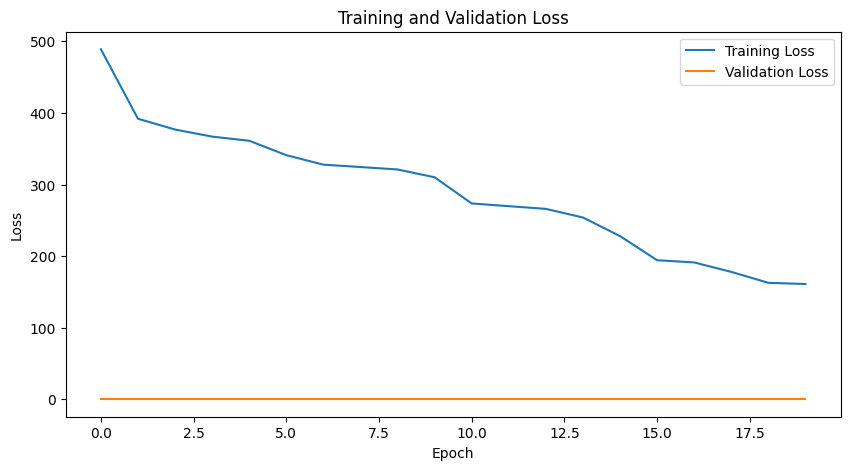

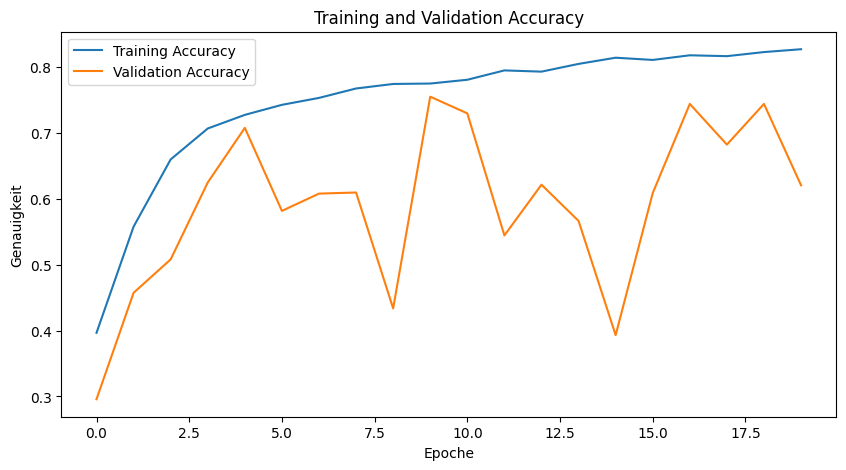

In [41]:
# Plot a graph for training and validation loss
plt.figure(figsize=(10, 5)) # Optionally specify the figure size
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a graph for training and validation accuracy
plt.figure(figsize=(10, 5)) # Optionally specify the figure size
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit') # If desired, you can use 'Genauigkeit' for the German word for 'Accuracy'
plt.legend()
plt.show()

In [26]:
# # Use the early stopping callback to halt training if validation loss doesn't improve
# early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# # Fit the model
# history = model.fit(
#     (X_train_spec, X_train_embed),
#     y_train,
#     epochs=100,
#     batch_size=32,
#     validation_data=((X_val_spec, X_val_embed), y_val),
#     callbacks=[early_stopper]
# )

# # history = model.fit((X_train_spec, X_train_embed), y_train, epochs=..., batch_size=..., validation_data=((X_val_spec, X_val_embed), y_val), ...)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [14]:
# class ModelSubClassing(keras.Model):
#     def __init__(self, num_classes, dim):
#         super().__init__()
#         # define all layers in init
#         # Layer of Block 1
#         self.conv1 = keras.layers.Conv2D(
#                           32, 3, strides=2, activation="relu"
#                      )
#         self.max1  = keras.layers.MaxPooling2D(3)
#         self.bn1   = keras.layers.BatchNormalization()

#         # Layer of Block 2
#         self.conv2 = keras.layers.Conv2D(64, 3, activation="relu")
#         self.bn2   = keras.layers.BatchNormalization()
#         self.max2  = keras.layers.MaxPooling2D(3)
#         self.drop  = keras.layers.Dropout(0.3)
        
#         # Layer of Block 3
#         self.conv3 = keras.layers.Conv2D(128, 3, activation="relu")
#         self.bn3   = keras.layers.BatchNormalization()
#         self.max3  = keras.layers.MaxPooling2D(3)
#         self.drop  = keras.layers.Dropout(0.3)

#         # flatten, followed by 3 dense layers 128, 64, 8
#         self.flatten   = keras.layers.Flatten()
#         self.dense128 = keras.layers.Dense(128)
#         self.dense64 = keras.layers.Dense(64)
#         self.dense8 = keras.layers.Dense(num_classes)


#     def call(self, input_tensor, training=False):
#         # forward pass: block 1 
#         x = self.conv1(input_tensor)
#         x = self.max1(x)
#         x = self.bn1(x)

#         # forward pass: block 2 
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.max2(x)
        
#         # forward pass: block 3
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.max3(x)

#         # droput followed by flatten and dense layers
#         x = self.drop(x)
#         x = self.flatten(x)
#         x = self.dense128(x)
#         x_dense64 = self.dense64(x)
#         y_hat = self.dense8(x_dense64)
#         return y_hat
    
#     def build_graph(self):
#         x = Input(shape=(dim))
#         return Model(inputs=[x], outputs=self.call(x))

In [ ]:
dummy_mel_spectrogram = np.random.random((1, 128, 1255, 1)).astype(np.float32)  # Batch size of 1
dummy_caption_embedding = np.random.random((1, 64)).astype(np.float32)  # Batch size of 1
# Convert the numpy data to tensors
dummy_mel_spectrogram_tf = tf.convert_to_tensor(dummy_mel_spectrogram)
dummy_caption_embedding_tf = tf.convert_to_tensor(dummy_caption_embedding)

# Pass the dummy data to the model
try:
    model((dummy_mel_spectrogram_tf, dummy_caption_embedding_tf), training=False)
    print("The model call was successful with the given input shapes.")
except Exception as e:
    print("An error occurred:", e)

model.summary()

In [15]:
# dim = (128, 1255, 1)

In [16]:
# sub_classing_model = ModelSubClassing(num_classes, dim)
# sub_classing_model.build((None, *dim))
# sub_classing_model.build_graph().summary()

2024-05-28 10:32:31.527853: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/layer.py:359: UserWarning: `build()` was called on layer 'model_sub_classing', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1255, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 63, 627, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 209, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 209, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 207, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 207, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 69, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 67, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 67, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 22, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 22, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       360,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,920 (1.77 MB)

 Trainable params: 462,472 (1.76 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
# sub_classing_model.compile(
#           loss      = keras.losses.CategoricalCrossentropy(),
#           metrics   = ['accuracy'],
#           optimizer = keras.optimizers.Adam())

In [18]:
# fit 
# sub_classing_model.fit(X_train, y_train, batch_size=128, epochs=1)

ValueError: For a model with multiple outputs, when providing the `metrics` argument as a list, it should have as many entries as the model has outputs. Received:
metrics=['accuracy']
of length 1 whereas the model has 2 outputs.

To create a custom model class in Keras with the specified architecture and custom loss function, we need to incorporate the two inputs and custom loss into the train_step method. Here’s how you can define and train such a model:

Define the model architecture to handle the two inputs.
Implement the train_step method to compute the custom loss.
Below is the complete implementation:

Explanation:
Model Architecture:

The ModelSubClassing class defines the layers in the __init__ method.
The call method specifies the forward pass using both inputs: the mel-spectrogram and the caption embedding.
Custom Training Step:

The train_step method is overridden to implement the custom loss function.
The custom loss combines the standard classification loss with the MSE between the caption embedding and the output of the dense layer of size 64.
Gradients are computed and applied to update the model’s weights.
Compilation and Training:

The model is compiled with an optimizer and loss function.
The model is trained using dummy data to illustrate the usage. In practice, you would replace the dummy data with your actual dataset.
This setup ensures that the model learns to minimize both the classification error and the difference between the caption embedding and the 64-dimensional dense layer output.

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

# class ModelSubClassing(keras.Model):
#     def __init__(self, num_classes):
#         super().__init__()
#         # Layer of Block 1
#         self.conv1 = Conv2D(32, 3, strides=2, activation="relu")
#         self.max1  = MaxPooling2D(3)
#         self.bn1   = BatchNormalization()

#         # Layer of Block 2
#         self.conv2 = Conv2D(64, 3, activation="relu")
#         self.bn2   = BatchNormalization()
#         self.max2  = MaxPooling2D(3)
#         self.drop1 = Dropout(0.3)
        
#         # Layer of Block 3
#         self.conv3 = Conv2D(128, 3, activation="relu")
#         self.bn3   = BatchNormalization()
#         self.max3  = MaxPooling2D(3)
#         self.drop2 = Dropout(0.3)

#         # Flatten, followed by 3 dense layers: 128, 64, num_classes
#         self.flatten   = Flatten()
#         self.dense128 = Dense(128, activation="relu")
#         self.dense64 = Dense(64, activation="relu")
#         self.dense_out = Dense(num_classes, activation="softmax")

#     def call(self, inputs, training=False):
#         # Unpack the inputs
#         mel_spectrogram, caption_embedding = inputs

#         # Forward pass: block 1
#         x = self.conv1(mel_spectrogram)
#         x = self.max1(x)
#         x = self.bn1(x)

#         # Forward pass: block 2
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.max2(x)
#         x = self.drop1(x, training=training)

#         # Forward pass: block 3
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.max3(x)
#         x = self.drop2(x, training=training)

#         # Flatten and dense layers
#         x = self.flatten(x)
#         x = self.dense128(x)
#         x_dense64 = self.dense64(x)
#         y_hat = self.dense_out(x_dense64)
        
#         return y_hat, x_dense64

#     def train_step(self, data):
#         # Unpack the data
#         (mel_spectrogram, caption_embedding), y = data

#         with tf.GradientTape() as tape:
#             y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=True)  # Forward pass
#             # Compute the standard loss value
#             loss = self.compiled_loss(y, y_pred)
#             # Add the custom loss component
#             custom_loss = tf.reduce_mean(tf.square(caption_embedding - x_dense64))
#             total_loss = loss + custom_loss

#         # Compute gradients
#         trainable_vars = self.trainable_variables
#         gradients = tape.gradient(total_loss, trainable_vars)

#         # Update weights
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))

#         # Update metrics (includes the metric that tracks the loss)
#         self.compiled_metrics.update_state(y, y_pred)

#         # Return a dict mapping metric names to current value
#         return {m.name: m.result() for m in self.metrics}

# # Example of using the custom model
# num_classes = 10  # Example number of output classes
# model = ModelSubClassing(num_classes)

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Create some dummy data
# import numpy as np
# X_mel = np.random.random((10, 128, 1255, 1))
# X_caption = np.random.random((10, 64))
# y = np.random.randint(0, num_classes, 10)

# # Train the model
# model.fit((X_mel, X_caption), y, epochs=3, batch_size=2)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
# from tensorflow.keras import Model

# # Define a custom model class
# class MyCustomModel(Model):
#     def __init__(self):
#         super(MyCustomModel, self).__init__()
#         # Initialize layers
#         self.conv1 = Conv2D(32, (3, 3), activation='relu')
#         self.pool1 = MaxPooling2D((2, 2))
#         self.conv2 = Conv2D(64, (3, 3), activation='relu')
#         self.pool2 = MaxPooling2D((2, 2))
#         self.flatten = Flatten()
#         self.dense1 = Dense(128, activation='relu')
#         self.dense2 = Dense(10, activation='softmax')
    
#     # Define the forward pass
#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.pool2(x)
#         x = self.flatten(x)
#         x = self.dense1(x)
#         return self.dense2(x)

# # Instantiate the model
# model = MyCustomModel()

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Print model summary (note that a summary can be printed only after the model is built)
# input_shape = (None, 28, 28, 1)  # Example input shape
# model.build(input_shape)
# model.summary()
